Tensorflow
===
Machine Learning on Cell phone
---
"Easy, fast, and fun" for doning such project? Not really. Insteadly, it is a long hard road.

Prebuilt Android Studio project involving tensorflow by ourself, one will require:

- Import the original TensorFlow Android sample sources
- Create a new Android Studio project (Company Name: org.tensorflow.demo), to have an already set up gradle configuration;
- Move TensorFlow’s Android sample files into the new gradle project;
- Remove the DetectorActivity and StylizeActivity (ClassifierActivity we need)
- Download the CI nightly prebuilt NDK libraries from this link and place those into your gradle project 
- Download the <a src="https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip">pre-trained ImageNet model (inception5h)</a> to assets folder.



Test on Jupyter with Python
---

In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.0.4


Using Inception
---
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [2]:
inet_model = inc_net.InceptionV3()

In [3]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

First Eye on the Power of prediction Results
---

('n02133161', 'American_black_bear', 0.63727742)
('n02105056', 'groenendael', 0.031802941)
('n02104365', 'schipperke', 0.029921521)
('n01883070', 'wombat', 0.028507346)
('n01877812', 'wallaby', 0.025098812)


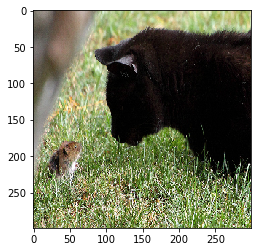

In [4]:
images = transform_img_fn([os.path.join('data','cat_mouse.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

How it Works
---
Now let's get an explanation

In [6]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [7]:
explainer = lime_image.LimeImageExplainer()

**hide_color** is the color for a superpixel turned OFF. Alternatively, if it is *NONE*, the superpixel will be replaced by the average of its pixels. Here, we set it to <font color="red">0</font> (in the representation used by inception model, <font color="red">0</font>  means <font color="gray">gray</font> )

In [8]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0], inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

CPU times: user 34min 27s, sys: 3min 44s, total: 38min 12s
Wall time: 5min 44s


Note
---
So long to compute. This is why CEO of Nvidia, Jenson Huang, is so proud their GPU product.

Now let's see the explanation for the top class ( Black Bear)
---

In [9]:
from skimage.segmentation import mark_boundaries

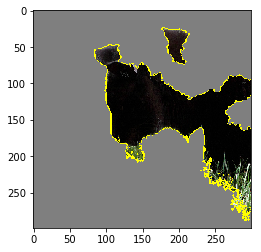

In [10]:
temp, mask = explanation.get_image_and_mask(295, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

**Or** with the rest of the image present:

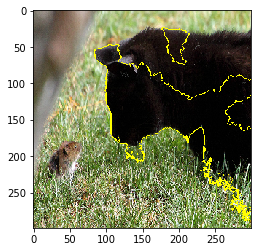

In [11]:
temp, mask = explanation.get_image_and_mask(295, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

We can also see the 'pros and cons' (pros in green, cons in red)

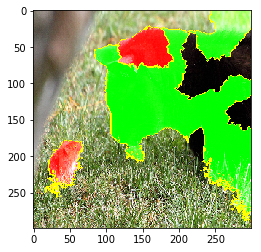

In [12]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

**Or** the pros and cons that have weight at least 0.1

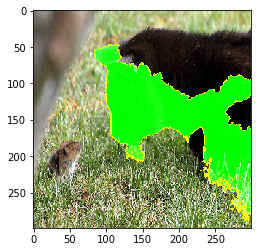

In [13]:
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Let's see the explanation for Wombat
---
Most positive towards wombat:

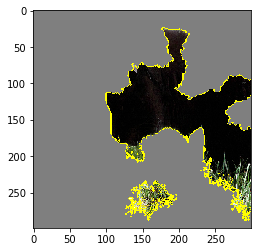

In [14]:
temp, mask = explanation.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

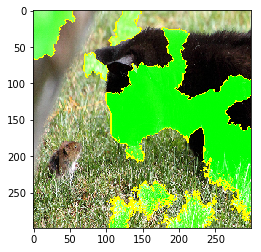

In [15]:
temp, mask = explanation.get_image_and_mask(106, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

To Summary the result, omit the the necessary in learning HOWTO, 8-(. But You can find the source codes and apk files in our web server:
- <a href="http://diffusion.cgu.edu.tw/math/tensorflowDemo">TensorflowDemo </a>

**1.** Create Image Classifier Model
---
- Gather lots of images: Inception works well with a various set of images; 
- create a ```~/tf_files/games``` folder and place each set of jpeg images in subdirectories (such as ```~/tf_files/games/mario, ~/tf_files/games/bomberman``` etc).

**2.** Retrain model
---
 
- retrain by the folloing script:
```shell
python tensorflow/examples/image_retraining/retrain.py \
  --bottleneck_dir=/tf_files/bottlenecks \
  --how_many_training_steps 4000 \
  --model_dir=/tf_files/inception \
  --output_graph=/tf_files/retrained_graph.pb \
  --output_labels=/tf_files/retrained_labels.txt \
  --image_dir /tf_files/games
```
- above, the script will generate two files: the model in a protobuf file (retrained_graph.pb) and a label list of all the objects it can recognize (retrained_labels.txt).

**3.** Optimize the model
---
The result can't be imported directly in Android Studio. We first need to optimize it first, using a tool named **optimize_for_inference**:
```shell
./configure # you can select all default values
bazel build tensorflow/python/tools:optimize_for_inference
```
about 20 minutes to completed.

Now the tool is built, you can optimize your model:
```shell
bazel-bin/tensorflow/python/tools/optimize_for_inference \
  --input=/tf_files/retrained_graph.pb \
  --output=/tf_files/retrained_graph_optimized.pb \
  --input_names=Mul \
  --output_names=final_result
```
This script will generate a ```~/tf_files/retrained_graph_optimized.pb``` file you will now be able into import in your Android project.



**4.** Tese the new model in Android app
---

After retraining model,
we can now delete the previous ImageNet model from our Android app’s assets folder and place the new model (~/tf_files/retrained_graph_optimized.pb and ~/tf_files/retrained_labels.txt) instead.

Also, we should update some constants in the ClassifierActivity.java, as specified in a comment in this same file:
```java
private static final int INPUT_SIZE = 299;
private static final int IMAGE_MEAN = 128;
private static final float IMAGE_STD = 128;
private static final String INPUT_NAME = "Mul";
private static final String OUTPUT_NAME = "final_result";

private static final String MODEL_FILE =
  "file:///android_asset/retrained_graph_optimized.pb";
private static final String LABEL_FILE =
  "file:///android_asset/retrained_labels.txt";
```

Android Things?
---
Using TensorFlow on Android Things is a little bit easier than on Android.
There is already an <a href="github.com/androidthings/sample-tensorflow-imageclassifier/">official gradle sample project</a> that works out-of-the-box with the ImageNet model, and which can be deployed quickly.

And if you want to use your own custom model instead, you will simply need to do exactly the same steps explained in this article (Android Things is Android, after all):

- Place your custom model (.pb and .txt files) in the assets directory
- Remove the .aar lib and use TensorFlow’s latest libs instead
- Modify the constants in the TensorFlowImageClassifier.java file